In [70]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
tf.__version__

'1.15.0-rc3'

In [71]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [72]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

In [73]:
# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.016987280920147896, -0.00894983857870102, -0.007062734570354223, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.03531336039304733, -0.025384224951267242, -0.007880032993853092, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [0.01879095658659935, 0.045365169644355774, -0.02001090534031391, ...]



In [81]:
range(len(messages))

range(0, 7)

In [82]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    print(corr)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=labels,
        yticklabels=labels,
        #vmin=0,
        #vmax=1,
        #cmap="YlOrRd"
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
    message_embeddings_ = session_.run(
        encoding_tensor, feed_dict={input_tensor_: messages_})
    plot_similarity(range(len(messages)), message_embeddings_, 90)

[[ 1.          0.6618576   0.7590882   0.61498404  0.08783934  0.19925869
   0.82372296  0.1046629   0.23204413]
 [ 0.6618576   0.9999994   0.732096    0.5316452   0.03828074  0.10064421
   0.5333955   0.05011687  0.13562548]
 [ 0.7590882   0.732096    0.9999999   0.581675    0.06201998  0.18563147
   0.69113266  0.08639628  0.11541518]
 [ 0.61498404  0.5316452   0.581675    1.0000001  -0.06060239  0.09857717
   0.66184324 -0.00711431  0.29748756]
 [ 0.08783934  0.03828074  0.06201998 -0.06060239  1.0000002   0.35700098
   0.06723492  0.51503754 -0.00152452]
 [ 0.19925869  0.10064421  0.18563147  0.09857717  0.35700098  1.
   0.19067462  0.5821632   0.15309688]
 [ 0.82372296  0.5333955   0.69113266  0.66184324  0.06723492  0.19067462
   1.          0.09976698  0.20208779]
 [ 0.1046629   0.05011687  0.08639628 -0.00711431  0.51503754  0.5821632
   0.09976698  1.          0.10421297]
 [ 0.23204413  0.13562548  0.11541518  0.29748756 -0.00152452  0.15309688
   0.20208779  0.10421297  0.99

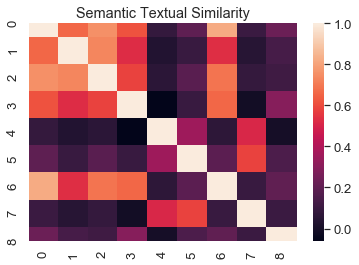

In [148]:
#first try is with abstracts. However, the model dilutes the embedding with longer sentences
messages = [
    # 1) Magnetic-field uniformity in neutron electric-dipole-moment experiments
    "Magnetic-field uniformity is of the utmost importance in experiments \
    to measure the electric dipole moment of the neutron. A general \
    parametrization of the magnetic field in terms of harmonic polynomial \
    modes is proposed, going beyond the linear-gradients approximation. \
    We review the main undesirable effects of nonuniformities: depolarization \
    of ultracold neutrons and Larmor frequency shifts of neutrons and mercury \
    atoms. The theoretical predictions for these effects were verified by \
    dedicated measurements with the single-chamber neutron \
    electric-dipole-moment apparatus installed at the Paul Scherrer Institute.",

    # 2) In Situ Study of the Stress Relaxation During Aging of Nickel-Base Superalloy Forgings
    "Nickel-base superalloys are conventionally aged in order to develop a favorable microstructure as well as to relieve residual stresses. Here neutron diffraction was used to follow the evolution of residual stress during aging in Inconel 718 and Udimet 720LI for the first time by a combination of in situ and ex situ measurements. First, the quench-induced stress profiles were determined for different geometries of Inconel 718 forgings confirming that the amplitude of stress is not significantly affected by the thickness of the component. It was followed by in situ residual stress analysis using neutron diffraction during aging/annealing treatments at 650 °C, 720 °C, and 750 °C. Almost 90 pct of stress relaxation was found to occur primarily during heating to the aging temperature as a result of a combination of plasticity and early-stage creep relaxation. Creep-like stress relaxation was observed to evolve at a diminishing rate during the isothermal treatment of Inconel 718 at 720 °C and 750 °C, while no further stress relaxation occurred at 650 °C. This means that a change in hold temperature might have a more immediate impact on stress relaxation than a change in duration of heat treatment. The post-aging ex situ measurements showed that a heat treatment at 750 °C for 8 hours reduced the stresses by approximately 70 pct in Inconel 718. By comparison, when heat treating Udimet 720LI in the same way only a 20 pct stress reduction was observed, which is explained by the higher creep resistance of this alloy.",

    #3) Structural, photoluminescent properties and Judd-Ofelt analysis of Eu3+-activated CaF2 nanocubes
    "Eu3+-doped CaF2 nanocubes with variable europium concentration, [Eu3+] = 0, 0.6, 1.3, 1.7, 2.2 and 5.4 mol%, have been synthesized by a direct precipitation route. It has been found that, within this concentration range, the nanoparticles present the fluoride-type crystalline structure and the characteristic cubic shape of CaF2 crystals. The nanoparticle size follows a log-normal distribution with a mean value decreasing with the Eu3+ content. Rietveld refinement has been performed to calculate the lattice parameter and crystallite size. Eu3+ concentration affects both parameters giving rise to an increase in the lattice parameter and a reduction of crystallite size. The luminescent properties of Eu3+ ions in these nanostructures have been investigated under CW and pulsed excitation. A Judd-Ofelt analysis, as function of the Eu3+ content, has been performed to determine the transition probabilities, radiative lifetimes and branching ratios of the 5D0 emitting level. It was found that  and  Judd-Ofelt intensity parameters are dependent on the doping level, showing an evolution that indicates a decrease in the Eu3+ site local symmetry with increasing Eu3+ concentration. Finally, it has been observed that the characteristic luminescence decay time of the 5D0 manifold is reduced with increasing Eu3+ concentration. This effect is partially due to an increase of radiative transition probability, associated with a reduction in the local symmetry of the lanthanide ions, and also to the occurrence of concentration quenching effects",
    
    # 4) The gravity of tacit knowledge flows in the presence of Information Communication Technologies
    "The role of geographical distance on the flow of knowledge has been debated in empirical work over the past decades. The magnitude of this relationship is usually attributed to the type of knowledge in question; in which tacit knowledge—the focus of the thesis—is usually associated with a negative relationship. The purpose of this thesis is to evaluate said role in the context of tacit knowledge flows, and in the presence of the diffusion of Information Communication Technologies (ICTs). Using data for international patent cooperation as proxy for tacit knowledge flows, a gravity model is implemented for an analysis of 48 countries and period 1993-2012. Although several attempts were implemented with numerous approaches, the presence of a negative relationship between geographical distance and tacit knowledge flows could not be contested within the context of ICT diffusion. This suggests evidence for the important role of geographical distance in the environment of face-to-face communication. The findings support current theoretical argumentation within the literature.",
    
     # 5) Egg
    "How much is that egg?",
    
    # 6) Bananas
    "Bananas are expensive",
    
    # 7) Search for the Standard Model Higgs boson at LEP
    "The four LEP Collaborations, ALEPH, DELPHI, L3 and OPAL, have collected a total of 2461 pb−1 of e+e− collision data at centre-of-mass energies between 189 and 209 GeV. The data are used to search for the Standard Model Higgs boson. The search results of the four Collaborations are combined and examined in a likelihood test for their consistency with two hypotheses: the background hypothesis and the signal plus background hypothesis. The corresponding confidences have been computed as functions of the hypothetical Higgs boson mass. A lower bound of 114.4 GeV/c2 is established, at the 95% confidence level, on the mass of the Standard Model Higgs boson. The LEP data are also used to set upper bounds on the HZZ coupling for various assumptions concerning the decay of the Higgs boson.",
    
     # 8) Eggs cont
    "Eggs are tasty",
    
    # 9) Information
    "The sharing of wisdom with the help of ICT",
    
]

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    run_and_plot(session, similarity_input_placeholder, messages,
                 similarity_message_encodings)

In [322]:
#now we try with article titles, although it won't necessarilly reflect what we want to achieve
#first try is with abstracts. However, the model dilutes the embedding with longer sentences
messages = [
    # 1) Magnetic-field uniformity in neutron electric-dipole-moment experiments
    "Magnetic-field uniformity in neutron electric-dipole-moment experiments",

    # 2) In Situ Study of the Stress Relaxation During Aging of Nickel-Base Superalloy Forgings
    "In Situ Study of the Stress Relaxation During Aging of Nickel-Base Superalloy Forgings",

    # 3) Structural, photoluminescent properties and Judd-Ofelt analysis of Eu3+-activated CaF2 nanocubes
    "Structural, photoluminescent properties and Judd-Ofelt analysis of Eu3+-activated CaF2 nanocubes",
    
    # 4) The gravity of tacit knowledge flows in the presence of Information Communication Technologies
    "The gravity of tacit knowledge flows in the presence of Information Communication Technologies",
    
    # 5) Egg
    "How much is that egg?",
    
    # 6) Bananas
    "Bananas are expensive",
    
    # 7) Search for the Standard Model Higgs boson at LEP
    "Search for the Standard Model Higgs boson at LEP",
    
    # 8) Eggs cont
    "Eggs are awesome",
    
    # 9) Information
    "The sharing of wisdom with the help of ICT",
    
]

[[ 0.9999999   0.50944805  0.602187    0.48117715  0.13476044  0.23738293
   0.6783908   0.19669387  0.4209676 ]
 [ 0.50944805  1.          0.46352312  0.4211195   0.05524221  0.05309966
   0.36011484  0.11906503  0.4092945 ]
 [ 0.602187    0.46352312  0.9999999   0.45079795  0.08404443  0.10459162
   0.554338    0.14902984  0.25286484]
 [ 0.48117715  0.4211195   0.45079795  0.99999994 -0.03341488  0.10561416
   0.52778316  0.07962906  0.5164384 ]
 [ 0.13476044  0.05524221  0.08404443 -0.03341488  1.0000002   0.35700098
   0.16072516  0.47743994 -0.00152452]
 [ 0.23738293  0.05309966  0.10459162  0.10561416  0.35700098  1.
   0.20779061  0.5526439   0.15309688]
 [ 0.6783908   0.36011484  0.554338    0.52778316  0.16072516  0.20779061
   0.9999999   0.12499017  0.31698364]
 [ 0.19669387  0.11906503  0.14902984  0.07962906  0.47743994  0.5526439
   0.12499017  1.0000002   0.16974881]
 [ 0.4209676   0.4092945   0.25286484  0.5164384  -0.00152452  0.15309688
   0.31698364  0.16974881  0.99

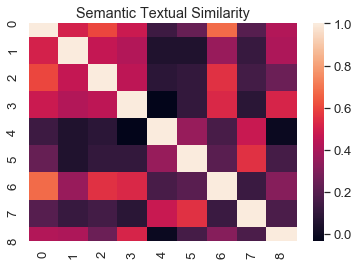

In [85]:
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    run_and_plot(session, similarity_input_placeholder, messages,
                 similarity_message_encodings)

In [86]:
#ELMo

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn import preprocessing

#!python -m spacy download en_core_web_md #you will need to install this on first load
import spacy
from spacy.lang.en import English
from spacy import displacy
nlp = spacy.load('en_core_web_md')
from IPython.display import HTML
import logging
logging.getLogger('tensorflow').disabled = True #OPTIONAL - to disable outputs from Tensorflow

In [2]:
url = "https://tfhub.dev/google/elmo/2"
embed = hub.Module(url)

In [323]:
embeddings = embed(
    messages,
    signature="default",
    as_dict=True)["default"]

embeddings.shape

TensorShape([Dimension(None), Dimension(512)])

In [324]:
%%time
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    x = sess.run(embeddings)
    
from sklearn.decomposition import PCA
n_components=2
pca = PCA(n_components=n_components)
y = pca.fit_transform(x)

#from sklearn.manifold import TSNE

#y = TSNE(n_components=2).fit_transform(y)

Wall time: 1min 39s


In [325]:
import chart_studio.plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)


data = [
    go.Scatter(
        x=[i[0] for i in y],
        y=[i[1] for i in y],
        mode='markers',
        text=[i for i in messages],
    marker=dict(
        size=16,
        color = [len(i) for i in messages], #set color equal to a variable
        opacity= 0.8,
        colorscale='Viridis',
        showscale=False
    )
    )
]
layout = go.Layout()
layout = dict(
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )
fig = go.Figure(data=data, layout=layout)
file = plot(fig, filename='Sentence encode test.html')

In [326]:
#sample from ILL
import pandas as pd
df = pd.read_excel('exp_PUB_ILL_opac.xlsx') #downloaded first three pages of publications- 300 articles- on 11/10/2019
#df=df.dropna()
#df.columns=['field','return']
df

,Document type,Number,Instrument,Domain,Authors,Journal title,Volume,Pages,Year,Title,...,Conference location,Conference date,Conference publishers,Issued by,Report number,Year.1,Proposal number,DOI,DOI added,WOS Number
0,Journal article,ILL19KU202,D11,NaN,"Kunze L., Tseng S.Y., Schweins R., Sottmann T....",Langmuir,35,5221-5231,2019.0,Nonionic aliphatic polycarbonate diblock copol...,...,NaN,NaN,NaN,NaN,NaN,NaN,9-10-1380,10.1021/acs.langmuir.8b04265,NaN,NaN
1,Journal article,ILL19LA1067,D2B,NaN,"Labégorre J.B., Virfeu A., Bourhim A., Willema...",Advanced Functional Materials,Online first,1904112-1-1904112-13,2019.0,"XBi4S7 (X = Mn, Fe): New cost?efficient layere...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1002/adfm.201904112,NaN,NaN
2,Dissertation,ILL19LA1026,NaN,NaN,Lang C.,NaN,NaN,NaN,NaN,Dynamics and phase behaviour of (non-)ideal li...,...,NaN,NaN,NaN,"PhD Thesis: Faculty of Science KU Leuve, Belgium",NaN,2019.0,NaN,NaN,NaN,NaN
3,Journal article,ILL19LA6057,NaN,NaN,"Larsen C.B., Romer A.T., Janas S., Treue F., M...",Physical Review B,99,054432-1-054432-12,2019.0,Exact diagonalization study of the Hubbard-par...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1103/PhysRevB.99.054432,NaN,NaN
4,Journal article,ILL19LA274,D16/D33,NaN,"Lassenberger A., Scheberl A., Batchu K.C., Cri...",ACS Applied Bio Materials,2,3095-3107,2019.0,Biocompatible glyconanoparticles by grafting s...,...,NaN,NaN,NaN,NaN,NaN,NaN,9-12-481,10.1021/acsabm.9b00427,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,Journal article,ILL19KR173,D11,NaN,"Krauss S.W., Schweins R., Magerl A., Zobel M.",Journal of Applied Crystallography,52,284-288,2019.0,Free-film small-angle neutron scattering: A no...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1107/S1600576719000906,NaN,NaN
306,Dissertation,ILL19KR1047,GAMS4,NaN,Kromer K.,NaN,NaN,NaN,NaN,Environmentally-induced systematic effects at ...,...,NaN,NaN,NaN,PhD Thesis: Max Planck Institute for Nuclear P...,NaN,2019.0,NaN,NaN,NaN,NaN
307,Journal article,ILL19KR1042,D2B,NaN,"Kruk I., Waldron J.E.L., Green M.A.",Inorganics,7,66-1-66-11,2019.0,Titanium doping of the metallic one-dimensiona...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.3390/inorganics7050066,NaN,NaN
308,Journal article,ILL19KU136,IN16B,"Applied Physics, Instrumentation and Techniques","Kuhlmann K., Appel M., Frick B., Magerl A.",Review of Scientific Instruments,90,015119-1-015119-7,2019.0,Breakthrough in neutron backscattering spectro...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1063/1.5046476,NaN,NaN


In [327]:
df.Title.dropna().shape

(300,)

In [328]:
messages = df.Title.dropna()
messages.shape

embeddings = embed(
    messages,
    signature="default",
    as_dict=True)["default"]

embeddings.shape

TensorShape([Dimension(None), Dimension(512)])

In [329]:
%%time
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    x = sess.run(embeddings)

Wall time: 1min 45s


In [330]:
from sklearn.decomposition import PCA
n_components=50
pca = PCA(n_components=n_components)
y = pca.fit_transform(x)

from sklearn.manifold import TSNE

y = TSNE(n_components=2).fit_transform(y)
y.shape

(300, 2)

In [331]:
import chart_studio.plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)


data = [
    go.Scatter(
        x=[i[0] for i in y],
        y=[i[1] for i in y],
        mode='markers',
        text=[i for i in messages],
    marker=dict(
        size=16,
        color = [len(i) for i in messages], #set color equal to a variable
        opacity= 0.8,
        colorscale='Viridis',
        showscale=False
    )
    )
]
layout = go.Layout()
layout = dict(
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )
fig = go.Figure(data=data, layout=layout)
file = plot(fig, filename='Titles encode 300ILL.html')